# Importing Libraries 

In [1]:
!pip install implicit

You should consider upgrading via the 'C:\Users\zhuzh\OneDrive\Desktop\AI Facial recognition\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,manhattan_distances
import seaborn as sns
import implicit 
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
sns.set(style = 'white')

# Data Preprocessing

In [3]:
df_cca=pd.read_csv('CCAPreferences.csv')
df_cca.drop(['UserID','Top 6 most preferred CCA','sum'], axis=1, inplace=True)

In [4]:
df_cca = df_cca.fillna(0)

one cca from each user has been selected as the test data and the index of the column that represents the selected cca is saved in a list.

In [5]:
grp_dict={}
test_data={}
grp = df_cca.groupby(['Gender','Age Group'])
for name, df in grp:
    df.drop(['Gender','Age Group'], axis=1, inplace=True)
    df=df.reset_index().drop(['index'],axis=1)
    df_mat=np.array(df)
    test_indxs=[]
    ### extract test data ###
    for i in range(len(df)):
        indxs=np.where(np.array(df.iloc[i])==1)[0]
        test_indx=np.random.choice(indxs, size=1)[0]
        df_mat[i][test_indx]=0
        test_indxs.append(test_indx)
    ##########################
    test_data[name]=test_indxs
    grp_dict[name]=df_mat
keys=list(grp_dict.keys())
ccas=np.array(df.columns)

In [6]:
df_anly=df_cca.groupby(['Gender','Age Group']).sum().reset_index()

In [7]:
df_anly['group id']=[i for i in range(len(df_anly))]

## model1 (features from user-cca matrix & cosine similarity)

vectors in the user-cca matrix have been directly used as feature vectors 

vectors of cca 1 =[0,1,0], cca 2=[0,1,1],cca 3=[1,1,0]

In [8]:
sim_mat_dic_m1={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    cca_similarity_matrix=cosine_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on cosine similarity
    sim_mat_dic_m1[keys[i]]=cca_similarity_matrix

## model 2 (features from Svd & cosine similarity)

svd to generate feature vectors

In [9]:
sim_mat_dic_m2={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    R = np.array(df).T
    mean = np.mean(R, axis = 1)
    data_matrix = R - mean.reshape(-1, 1)
    U, sigma, Vt = svds(data_matrix, k = np.min(data_matrix.shape)-1)
    sigma = np.diag(sigma)
    feature_matrix=np.dot(U, sigma)
    cca_similarity_matrix=cosine_similarity(feature_matrix,feature_matrix) #Find the user-similarity matrix based on cosine similarity
    sim_mat_dic_m2[keys[i]]=cca_similarity_matrix

## Model3 (features from user-cca matrix & euclidean distance similarity)

In [10]:
def euclidean_similarity(matrix1,matrix2):
    euclidean_dist=euclidean_distances(matrix1,matrix2)#find distance 
    scaler = MinMaxScaler()#scale it
    # 
    euclidean_dist_scaled = scaler.fit_transform(euclidean_dist)
    euclidean_sim=1-euclidean_dist_scaled #minus 1 to find similarity 
    return(euclidean_sim)

In [11]:
sim_mat_dic_m3={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    cca_similarity_matrix=euclidean_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on ed similarity
    sim_mat_dic_m3[keys[i]]=cca_similarity_matrix

## Model4 (features from user-cca matrix & manhattan distance similarity)

In [12]:
def manhattan_similarity(matrix1,matrix2):
    manhattan_dist=manhattan_distances(matrix1,matrix2)#find distance 
    scaler = MinMaxScaler()#scale it
    # transform data
    manhattan_dist_scaled = scaler.fit_transform(manhattan_dist)
    manhattan_sim=1-manhattan_dist_scaled #minus 1 to find similarity 
    return(manhattan_sim)


In [13]:
sim_mat_dic_m5={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    cca_similarity_matrix= manhattan_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on md similarity
    sim_mat_dic_m5[keys[i]]=cca_similarity_matrix

# Evaluating models part


In [14]:
def rmse_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###test data take from indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    err=np.sqrt(np.mean((test-1)**2)) # calculation of  error
    return(err)

In [15]:
def mse_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###test data take from indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    err=np.mean((test-1)**2) # calculation of  error
    return(err)

In [16]:
def mape_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###test data take from indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    err=np.mean(abs(test-1)) # calculation of  error
    return(err)

In [17]:
cosine_rmse=[]
svd_rmse=[]
euclidean_rmse=[]
mahanttan_rmse=[]


cosine_mse=[]
svd_mse=[]
euclidean_mse=[]
mahanttan_mse=[]


cosine_mape=[]
svd_mape=[]
euclidean_mape=[]
mahanttan_mape=[]


for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    weight=(1/np.sum(data_matrix!=0,axis=0))
    cca_similarity_matrix_m1=sim_mat_dic_m1[keys[i]]
    cca_similarity_matrix_m2=sim_mat_dic_m2[keys[i]]
    cca_similarity_matrix_m3=sim_mat_dic_m3[keys[i]]
    cca_similarity_matrix_m5=sim_mat_dic_m5[keys[i]]
    data_matrix_filed_m1=data_matrix+np.matmul(data_matrix.T,cca_similarity_matrix_m1).T*(data_matrix==0)*weight
    data_matrix_filed_m2=data_matrix+np.matmul(data_matrix.T,cca_similarity_matrix_m2).T*(data_matrix==0)*weight
    data_matrix_filed_m3=data_matrix+np.matmul(data_matrix.T,cca_similarity_matrix_m3).T*(data_matrix==0)*weight
    data_matrix_filed_m5=data_matrix+np.matmul(data_matrix.T,cca_similarity_matrix_m5).T*(data_matrix==0)*weight

    #rmse 
    cosine_rmse.append(rmse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    svd_rmse.append(rmse_calc(data_matrix_filed_m2,test_data[keys[i]])) 
    euclidean_rmse.append(rmse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mahanttan_rmse.append(rmse_calc(data_matrix_filed_m5,test_data[keys[i]])) 
  

    #mse
    cosine_mse.append(mse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    svd_mse.append(rmse_calc(data_matrix_filed_m2,test_data[keys[i]])) 
    euclidean_mse.append(mse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mahanttan_mse.append(mse_calc(data_matrix_filed_m5,test_data[keys[i]]))
  

    #mape
    cosine_mape.append(mape_calc(data_matrix_filed_m1,test_data[keys[i]]))
    svd_mape.append(mape_calc(data_matrix_filed_m2,test_data[keys[i]]))
    euclidean_mape.append(mape_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mahanttan_mape.append(mape_calc(data_matrix_filed_m5,test_data[keys[i]]))
    ############################################################

In [18]:
rmse_m1=[]
rmse_m2=[]
rmse_m3=[]
rmse_m5=[]
mse_m1=[]
mse_m2=[]
mse_m3=[]
mse_m5=[]

mape_m1=[]
mape_m2=[]
mape_m3=[]
mape_m5=[]
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    weight=(1/np.sum(data_matrix!=0,axis=0))
    food_similarity_matrix_m1=sim_mat_dic_m1[keys[i]]
    food_similarity_matrix_m2=sim_mat_dic_m2[keys[i]]
    food_similarity_matrix_m3=sim_mat_dic_m3[keys[i]]
    food_similarity_matrix_m5=sim_mat_dic_m5[keys[i]]
    data_matrix_filed_m1=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m1).T*(data_matrix==0)*weight
    data_matrix_filed_m2=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m2).T*(data_matrix==0)*weight
    data_matrix_filed_m3=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m3).T*(data_matrix==0)*weight
    data_matrix_filed_m5=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m5).T*(data_matrix==0)*weight
    rmse_m1.append(rmse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    rmse_m2.append(rmse_calc(data_matrix_filed_m2,test_data[keys[i]]))
    rmse_m3.append(rmse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    rmse_m5.append(rmse_calc(data_matrix_filed_m5,test_data[keys[i]]))  
    mse_m1.append(mse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    mse_m2.append(mse_calc(data_matrix_filed_m2,test_data[keys[i]]))
    mse_m3.append(mse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mse_m5.append(mse_calc(data_matrix_filed_m5,test_data[keys[i]]))  
    mape_m1.append(mape_calc(data_matrix_filed_m1,test_data[keys[i]]))
    mape_m2.append(mape_calc(data_matrix_filed_m2,test_data[keys[i]]))
    mape_m3.append(mape_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mape_m5.append(mape_calc(data_matrix_filed_m5,test_data[keys[i]]))
    ############################################################

values  be predicted using the this

**rating_**{(i,j)} = similarity\_matrix_i * data\_matrix_j*weight  


where, \


similarity\_matrix_i=$ i th raw of user_similarity_matrix\
 data\_matrix_j= j th column of data_matrix_useritem\
weight=1/sum(data\_matrix\_useritem_j !=0)



# Plotting Line Graph with markers at each point 

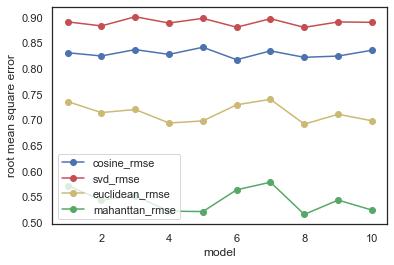

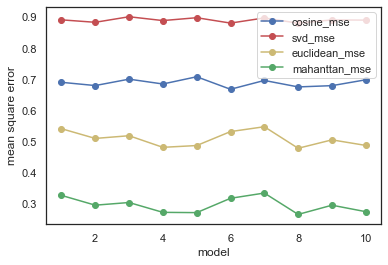

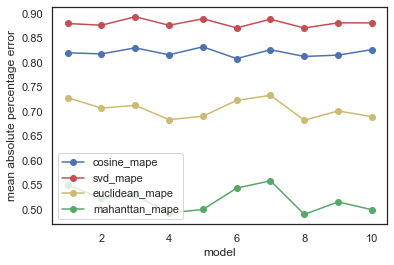

In [19]:
plt.plot([i+1 for i in range(len(cosine_rmse))],cosine_rmse,'b',label='cosine_rmse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],svd_rmse,'r',label='svd_rmse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],euclidean_rmse,'y',label='euclidean_rmse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],mahanttan_rmse,'g',label='mahanttan_rmse', marker = 'o')

plt.legend()
plt.xlabel('model')
plt.ylabel('root mean square error')
plt.show()

plt.plot([i+1 for i in range(len(cosine_rmse))],cosine_mse,'b',label='cosine_mse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],svd_mse,'r',label='svd_mse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],euclidean_mse,'y',label='euclidean_mse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],mahanttan_mse,'g',label='mahanttan_mse', marker = 'o')

plt.legend()
plt.xlabel('model')
plt.ylabel('mean square error')
plt.show()


plt.plot([i+1 for i in range(len(cosine_rmse))],cosine_mape,'b',label='cosine_mape', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],svd_mape,'r',label='svd_mape', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],euclidean_mape,'y',label='euclidean_mape', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],mahanttan_mape,'g',label='mahanttan_mape', marker = 'o')


plt.legend()
plt.xlabel('model')
plt.ylabel('mean absolute percentage error')
plt.show()

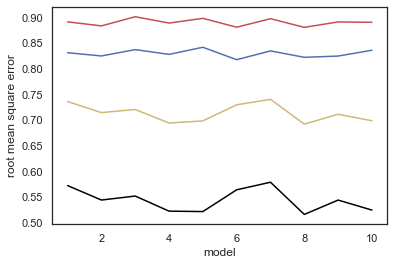

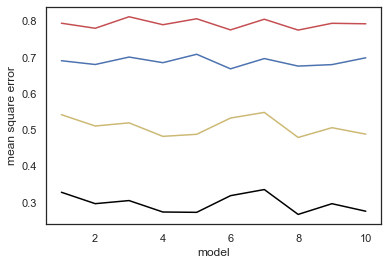

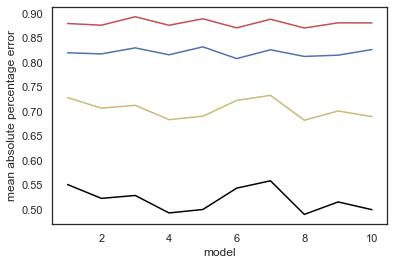

In [20]:
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m1,'b',label='rmse_m1')
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m2,'r',label='rmse_m2')
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m3,'y',label='rmse_m3')
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m5,'black',label='rmse_m5')
# plt.legend()
plt.xlabel('model')
plt.ylabel('root mean square error')
plt.show()

plt.plot([i+1 for i in range(len(rmse_m1))],mse_m1,'b',label='mse_m1')
plt.plot([i+1 for i in range(len(rmse_m1))],mse_m2,'r',label='mse_m2')
plt.plot([i+1 for i in range(len(rmse_m1))],mse_m3,'y',label='mse_m3')
plt.plot([i+1 for i in range(len(rmse_m1))],mse_m5,'black',label='mse_m5')
# plt.legend()
plt.xlabel('model')
plt.ylabel('mean square error')
plt.show()


plt.plot([i+1 for i in range(len(rmse_m1))],mape_m1,'b',label='mape_m1')
plt.plot([i+1 for i in range(len(rmse_m1))],mape_m2,'r',label='mape_m2')
plt.plot([i+1 for i in range(len(rmse_m1))],mape_m3,'y',label='mape_m3')
plt.plot([i+1 for i in range(len(rmse_m1))],mape_m5,'black',label='mape_m5')
# plt.legend()
plt.xlabel('model')
plt.ylabel('mean absolute percentage error')
plt.show()

# **RMSE **

In [21]:
a=cosine_rmse
b=svd_rmse
c=euclidean_rmse
d=mahanttan_rmse

print(a)
print(b)
print(c)
print(d)

[0.8309722942214481, 0.8246733819487224, 0.8370407544624852, 0.8277142538756754, 0.841624031717127, 0.8174006127100415, 0.8345449114259996, 0.8220158155651901, 0.8244876990044545, 0.8358256879727857]
[0.8910961029001775, 0.8832300642534232, 0.9010626180878274, 0.8887586948116662, 0.897954678309605, 0.880674756133849, 0.8972361694226916, 0.8803704034452641, 0.8909665552731263, 0.8902125277824345]
[0.7359128474588996, 0.7143563295381378, 0.7204007076213184, 0.6940629207522927, 0.6981802867672382, 0.7295668238789693, 0.7401907156846368, 0.6918781720791647, 0.711116050866515, 0.6984472452820734]
[0.5722086868172871, 0.5440134124599203, 0.5518135088308519, 0.522413476384507, 0.5215652098580928, 0.5639560314017269, 0.5787321819790355, 0.5160262002325345, 0.5439540347863504, 0.5244716881465635]


# **MSE Group**

In [22]:
a=cosine_mse
b=svd_mse
c=euclidean_mse
d=mahanttan_mse

print(a)
print(b)
print(c)
print(d)

[0.6905149537636569, 0.6800861868947434, 0.7006372246311264, 0.6851108860689661, 0.7083310107637915, 0.6681437616587512, 0.6964652091870295, 0.6757100010393046, 0.67977996580966, 0.6986045806751805]
[0.8910961029001775, 0.8832300642534232, 0.9010626180878274, 0.8887586948116662, 0.897954678309605, 0.880674756133849, 0.8972361694226916, 0.8803704034452641, 0.8909665552731263, 0.8902125277824345]
[0.5415677190550656, 0.5103049655512004, 0.5189771795412962, 0.4817233379632033, 0.4874557128303829, 0.5322677505048471, 0.5478822955857349, 0.4786954049996063, 0.5056860377999879, 0.4878285544421168]
[0.32742278126916413, 0.29595059293628734, 0.3044981485282167, 0.27291584030814586, 0.27203026813431647, 0.31804640535438555, 0.3349309384582155, 0.26628303932642783, 0.29588599196035015, 0.27507055166730615]


# **MAPE group**

In [23]:
a5=cosine_mape
b5=svd_mape
c5=euclidean_mape
d5=mahanttan_mape

print(a5)
print(b5)
print(c5)
print(d5)

[0.8192824072661101, 0.8169352086939344, 0.8292503900315126, 0.815131772476272, 0.8313461422817492, 0.807396715872227, 0.8254130317986771, 0.8117506597119889, 0.8144085467244871, 0.8257396796442296]
[0.8790302773837434, 0.87547886263826, 0.8927970984316204, 0.8753822280834747, 0.888612287720708, 0.8701320243502375, 0.887702355649286, 0.8698126761351951, 0.8803440141313562, 0.8802447983109365]
[0.7277619197765571, 0.706208965917469, 0.7120234381660742, 0.6827617345798906, 0.6896618327990023, 0.7220151572851097, 0.7323638415870155, 0.6816365926707632, 0.7005042980632279, 0.6888547602943763]
[0.5503115167660623, 0.5220630341138363, 0.528008521781249, 0.49231743568374586, 0.49935184067269633, 0.5429614678251042, 0.5579300346118528, 0.4893098517643973, 0.5148040088253991, 0.4989531276804005]


# Prediction , recommend top 5

In [24]:
def recommend(Gender,Age_Group,cca,sim_mat,top_n):
    sim_mat=sim_mat[(Gender,Age_Group)]#get which gender and agegroup then see which model to use
    idx=np.where(ccas==cca)[0][0]# get the cca and look through
    sim_array=sim_mat[idx]#put the index from the previous line into the sim_mat
    sim_array[idx]=-1000 # minus 1000 to get the idx, forcing that value to large negetive value.
    scores=list(enumerate(sim_array))#To specify each course of a sequence individually
    sorted_array=np.array(sorted(scores,key=lambda x: x[1], reverse=True),dtype='uint8')[:,0]# sort and print top 5
    print(ccas[sorted_array[:top_n]])

# **Testing with test cases**

In [26]:
Gender='Female'
Age_Group='15 - 24'
cca='Adventure Club '
recommend(Gender,Age_Group,cca,sim_mat_dic_m1,5)
recommend(Gender,Age_Group,cca,sim_mat_dic_m2,5)
recommend(Gender,Age_Group,cca,sim_mat_dic_m3,5)
recommend(Gender,Age_Group,cca,sim_mat_dic_m5,5)

['Dragonboat ' 'Canoe Sprint ' 'Life Saving ' 'Swimming ' 'Athletics ']
['Dragonboat ' 'Canoe Sprint ' 'Swimming ' 'Life Saving ' 'Athletics ']
['Dragonboat ' 'Canoe Sprint ' 'Life Saving ' 'Swimming ' 'Athletics ']
['Dragonboat ' 'Canoe Sprint ' 'Life Saving ' 'Swimming ' 'Athletics ']
